In [1]:
def account(data, cap, fee):
    data1 = data.copy()
    data1['cash'] = cap
    data1['fee'] = np.where(data1['buyorsell'] != 0, fee, 0)
    data1['open_position'] = 0.0
    data1['traded_nominal_val'] = 0.0
    data1['unrealised_P&L'] = 0.0
    data1['cashflow'] = 0.0
    data1['total_assets'] = data1['cash'] + data1['traded_nominal_val']
    data1['net_assets'] = 0.0
    
    for i in range(1, len(data1)):
        
        if data1['buyorsell'][i] == 1:
            
            if data['pos'][i] == 1: # buy to open a long position
                
                data1['open_position'][i:] = data1['pos'][i] * ((data1['cash'][i] - data1['fee'][i]) // data1['spread_cap_req'][i])

                data1['traded_nominal_val'][i:] = data1['open_position'][i] * data1['spot_spread'][i]
                
                data1['cashflow'][i] = (-data1['traded_nominal_val'][i] - data1['fee'][i])

                data1['cash'][i:] = data1['cash'][i-1] + data1['cashflow'][i]

                data1['total_assets'][i:] = data1['cash'][i] + data1['traded_nominal_val'][i]
                
            elif data['pos'][i] == 0: # buy to close a short position
                
                data1['open_position'][i:] = data1['pos'][i]

                data1['traded_nominal_val'][i:] = data1['open_position'][i] * data1['spot_spread'][i]

                data1['cashflow'][i] = (((data1['open_position'][i-1] * data1['spot_spread'][i] ) - data1['fee'][i]) - data1['traded_nominal_val'][i-1])

                data1['cash'][i:] = data1['cash'][i-1] + data1['cashflow'][i]

                data1['total_assets'][i:] = data1['cash'][i] + data1['traded_nominal_val'][i]

        elif data1['buyorsell'][i] == -1:
            
            if data['pos'][i] == -1: # sell to open a short position
                
                data1['open_position'][i:] = data1['pos'][i] * ((data1['cash'][i] - data1['fee'][i]) // data1['spread_cap_req'][i])

                data1['traded_nominal_val'][i:] = data1['open_position'][i] * data1['spot_spread'][i]

                data1['cashflow'][i] = ( - data1['fee'][i])

                data1['cash'][i:] = data1['cash'][i-1] + data1['cashflow'][i]

                data1['total_assets'][i:] = data1['cash'][i]
                
                
            elif data['pos'][i] == 0: # sell to close a long position
                
                data1['open_position'][i:] = data1['pos'][i]
                
                data1['traded_nominal_val'][i:] = data1['open_position'][i] * data1['spot_spread'][i]
                
                data1['cashflow'][i] = ((data1['open_position'][i-1] * data1['spot_spread'][i]) - data1['fee'][i])
                
                data1['cash'][i:] = data1['cash'][i-1] + data1['cashflow'][i] - data1['traded_nominal_val'][i]
                
                data1['total_assets'][i:] = data1['cash'][i] + data1['traded_nominal_val'][i]                                                        
        
    data1['unrealised_P&L'] = (data1['open_position'] * data1['spot_spread']) - data1['traded_nominal_val']  
    data1['net_assets'] = data1['cash'] + data1['traded_nominal_val'] + data1['unrealised_P&L']
    data1['strat_acc_return_pct_chg'] = (data1['total_assets']).pct_change()
    data1['strat_acc_return_nplog'] = (data1['total_assets'] / data1['total_assets'].shift(1)).apply(np.log)
    data1['cumsum_strat_acc'] = data1['strat_acc_return_nplog'].cumsum().apply(np.exp)
    data1['max_performance_acc'] = data1['cumsum_strat_acc'].cummax()
    data1['drawdown_acc'] = data1['max_performance_acc'] - data1['cumsum_strat_acc']

    
    return data1

In [2]:
import numpy as np
import random
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.arima.model as stats

from pandas.plotting import scatter_matrix
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf

In [3]:
import warnings
warnings.filterwarnings('once')

In [4]:
from statsmodels.tsa.stattools import adfuller

In [5]:
import yfinance as yf
import pandas_datareader.data as pdr

C:\Users\24146\anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:11: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  PANDAS_VERSION = LooseVersion(pd.__version__)


In [6]:
def extract(tickers, s, e):
    def data(t):
        return pdr.get_data_yahoo(t, s, e)[['Close']]
    
    stock_data = map(data, tickers)
    data_con = pd.concat(stock_data, axis = 1)
    data_con.columns = tickers
    return data_con

In [7]:
stocks = ['ING', 'MS']

In [8]:
df = extract(stocks, '2020-1-1', '2022-1-1')
df.columns = stocks

C:\Users\24146\anaconda3\lib\site-packages\pandas_datareader\data.py:80: ResourceWarning: unclosed <ssl.SSLSocket fd=4708, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.119.35.225', 64323), raddr=('119.161.10.12', 443)>
  return YahooDailyReader(*args, **kwargs).read()
C:\Users\24146\anaconda3\lib\site-packages\pandas_datareader\data.py:80: ResourceWarning: unclosed <ssl.SSLSocket fd=4712, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.119.35.225', 64324), raddr=('119.161.10.12', 443)>
  return YahooDailyReader(*args, **kwargs).read()


In [9]:
df[df.isnull() == True].sum()

ING    0.0
MS     0.0
dtype: float64

<AxesSubplot:xlabel='Date'>

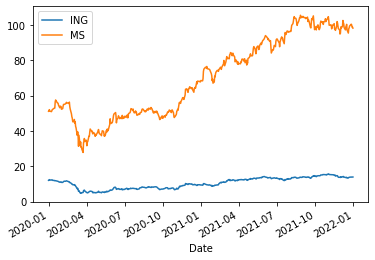

In [10]:
df.plot()

In [11]:
model = sm.OLS(df[stocks[0]], sm.add_constant(df[stocks[1]])).fit()

In [12]:
model.params

const    1.719641
MS       0.125158
dtype: float64

In [13]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ING   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     3068.
Date:                Mon, 31 Oct 2022   Prob (F-statistic):          1.80e-216
Time:                        21:36:05   Log-Likelihood:                -788.70
No. Observations:                 506   AIC:                             1581.
Df Residuals:                     504   BIC:                             1590.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7196      0.166     10.374      0.000       1.394       2.045
MS             0.1252      0.002     55.392      0.000       0.121       0.130
==============================================================================
Omnibus:                      130.351   Durbin-Watson:                   0.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              267.136
Skew:                           1.401   Prob(JB):                     9.82e-59
Kurtosis:                       5.194   Cond. No.                         237.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
model.resid

Date
2019-12-31    3.932296
2020-01-02    4.197151
2020-01-03    4.072283
2020-01-06    4.084811
2020-01-07    4.117327
                ...   
2021-12-27   -0.375478
2021-12-28   -0.371660
2021-12-29   -0.186464
2021-12-30   -0.205226
2021-12-31   -0.085125
Length: 506, dtype: float64

In [15]:
adfuller(model.resid)

(-3.464824347564779,
 0.00893779249358812,
 0,
 505,
 {'1%': -3.44336554668393,
  '5%': -2.867280279529963,
  '10%': -2.5698273512400744},
 -231.3069828939299)

In [35]:
df_testing = extract(stocks, '2022-1-1', '2022-10-30')
df_testing

C:\Users\24146\anaconda3\lib\site-packages\pandas_datareader\data.py:80: ResourceWarning: unclosed <ssl.SSLSocket fd=4880, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.119.35.225', 64469), raddr=('119.161.10.11', 443)>
  return YahooDailyReader(*args, **kwargs).read()
C:\Users\24146\anaconda3\lib\site-packages\pandas_datareader\data.py:80: ResourceWarning: unclosed <ssl.SSLSocket fd=4880, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.119.35.225', 64470), raddr=('119.161.10.11', 443)>
  return YahooDailyReader(*args, **kwargs).read()


,ING,MS
Date,,
2021-12-31,13.92,98.160004
2022-01-03,14.08,100.190002
2022-01-04,14.33,104.260002
2022-01-05,14.38,101.680000
2022-01-06,14.70,103.419998
...,...,...
2022-10-24,9.75,79.430000
2022-10-25,9.84,80.510002
2022-10-26,9.86,80.910004


In [47]:
df_testing['spot_spread'] = df_testing[stocks[0]] - model.params[1] * df_testing[stocks[1]]
df_testing['positive_2std'] = model.params[0] + (3 * 0.166)
df_testing['negative_2std'] = model.params[0] - (3 * 0.166)
df_testing['spot_spread_diff'] = df_testing['spot_spread'] - model.params[0]
df_testing['pos'] = np.where(df_testing['spot_spread'] > df_testing['positive_2std'], -1, np.nan)
df_testing['pos'] = np.where(df_testing['spot_spread'] < df_testing['negative_2std'], 1, df_testing['pos'])
df_testing['pos'] = np.where((df_testing['spot_spread_diff'] * df_testing['spot_spread_diff'].shift(1)) < 0, 0, df_testing['pos'])
df_testing['pos'] = df_testing['pos'].ffill().fillna(0)
df_testing['buyorsell'] = df_testing['pos'].diff()
df_testing['spread_cap_req'] = df_testing[stocks[0]] + model.params[1] * df_testing[stocks[1]]


In [48]:
df_testing['buyorsell'].value_counts()

 0.0    203
 1.0      3
-1.0      2
Name: buyorsell, dtype: int64

In [49]:
df_testing.loc['2022']

,ING,MS,spot_spread,positive_2std,negative_2std,spot_spread_diff,pos,buyorsell,spread_cap_req
Date,,,,,,,,,
2022-01-03,14.08,100.190002,1.540446,2.217641,1.221641,-0.179195,0.0,0.0,26.619554
2022-01-04,14.33,104.260002,1.281054,2.217641,1.221641,-0.438587,0.0,0.0,27.378946
2022-01-05,14.38,101.680000,1.653961,2.217641,1.221641,-0.065680,0.0,0.0,27.106039
2022-01-06,14.70,103.419998,1.756187,2.217641,1.221641,0.036546,0.0,0.0,27.643813
2022-01-07,14.88,104.050003,1.857337,2.217641,1.221641,0.137696,0.0,0.0,27.902663
...,...,...,...,...,...,...,...,...,...
2022-10-24,9.75,79.430000,-0.191279,2.217641,1.221641,-1.910920,1.0,0.0,19.691279
2022-10-25,9.84,80.510002,-0.236450,2.217641,1.221641,-1.956091,1.0,0.0,19.916450
2022-10-26,9.86,80.910004,-0.266513,2.217641,1.221641,-1.986154,1.0,0.0,19.986513


In [50]:
(14.70 - (103.419998 * 0.125158)) - (14.33 - (104.260002 * 0.125158))

0.4751332206319976

In [51]:
a = (14.70-14.33) * 1000
a

369.9999999999992

In [52]:
b = ((104.260002 - 103.419998)*0.125158)*1000
b

105.13322063199917

In [53]:
a + b

475.13322063199837

In [54]:
df_acc_testing = account(df_testing, 100000, 5)
df_acc_testing

C:\Users\24146\AppData\Local\Temp\ipykernel_11240\2212312694.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['open_position'][i:] = data1['pos'][i] * ((data1['cash'][i] - data1['fee'][i]) // data1['spread_cap_req'][i])


,ING,MS,spot_spread,positive_2std,negative_2std,spot_spread_diff,pos,buyorsell,spread_cap_req,cash,...,traded_nominal_val,unrealised_P&L,cashflow,total_assets,net_assets,strat_acc_return_pct_chg,strat_acc_return_nplog,cumsum_strat_acc,max_performance_acc,drawdown_acc
Date,,,,,,,,,,,,,,,,,,,,,
2021-12-31,13.92,98.160004,1.634516,2.217641,1.221641,-0.085125,0.0,NaN,26.205484,100000.000000,...,0.000000,0.000000,0.0,100000.000000,100000.000000,NaN,NaN,NaN,NaN,NaN
2022-01-03,14.08,100.190002,1.540446,2.217641,1.221641,-0.179195,0.0,0.0,26.619554,100000.000000,...,0.000000,0.000000,0.0,100000.000000,100000.000000,0.0,0.0,1.000000,1.000000,0.00000
2022-01-04,14.33,104.260002,1.281054,2.217641,1.221641,-0.438587,0.0,0.0,27.378946,100000.000000,...,0.000000,0.000000,0.0,100000.000000,100000.000000,0.0,0.0,1.000000,1.000000,0.00000
2022-01-05,14.38,101.680000,1.653961,2.217641,1.221641,-0.065680,0.0,0.0,27.106039,100000.000000,...,0.000000,0.000000,0.0,100000.000000,100000.000000,0.0,0.0,1.000000,1.000000,0.00000
2022-01-06,14.70,103.419998,1.756187,2.217641,1.221641,0.036546,0.0,0.0,27.643813,100000.000000,...,0.000000,0.000000,0.0,100000.000000,100000.000000,0.0,0.0,1.000000,1.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-24,9.75,79.430000,-0.191279,2.217641,1.221641,-1.910920,1.0,0.0,19.691279,102858.916072,...,4460.452679,-5291.751831,0.0,107319.368751,102027.616920,0.0,0.0,1.073194,1.073244,0.00005
2022-10-25,9.84,80.510002,-0.236450,2.217641,1.221641,-1.956091,1.0,0.0,19.916450,102858.916072,...,4460.452679,-5488.062534,0.0,107319.368751,101831.306217,0.0,0.0,1.073194,1.073244,0.00005
2022-10-26,9.86,80.910004,-0.266513,2.217641,1.221641,-1.986154,1.0,0.0,19.986513,102858.916072,...,4460.452679,-5618.719731,0.0,107319.368751,101700.649020,0.0,0.0,1.073194,1.073244,0.00005


In [55]:
df_acc_testing['2022-10']

C:\Users\24146\AppData\Local\Temp\ipykernel_11240\838784737.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df_acc_testing['2022-10']


,ING,MS,spot_spread,positive_2std,negative_2std,spot_spread_diff,pos,buyorsell,spread_cap_req,cash,...,traded_nominal_val,unrealised_P&L,cashflow,total_assets,net_assets,strat_acc_return_pct_chg,strat_acc_return_nplog,cumsum_strat_acc,max_performance_acc,drawdown_acc
Date,,,,,,,,,,,,,,,,,,,,,
2022-10-03,8.71,80.379997,-1.350179,2.217641,1.221641,-3.069820,1.0,0.0,18.770179,102858.916072,...,4460.452679,-10328.328757,0.0,107319.368751,96991.039994,0.0,0.0,1.073194,1.073244,0.00005
2022-10-04,9.50,83.970001,-1.009495,2.217641,1.221641,-2.729136,1.0,0.0,20.009495,102858.916072,...,4460.452679,-8847.719626,0.0,107319.368751,98471.649125,0.0,0.0,1.073194,1.073244,0.00005
2022-10-05,9.13,83.110001,-1.271860,2.217641,1.221641,-2.991500,1.0,0.0,19.531860,102858.916072,...,4460.452679,-9987.954243,0.0,107319.368751,97331.414508,0.0,0.0,1.073194,1.073244,0.00005
2022-10-06,8.87,81.309998,-1.306575,2.217641,1.221641,-3.026216,1.0,0.0,19.046575,102858.916072,...,4460.452679,-10138.829627,0.0,107319.368751,97180.539124,0.0,0.0,1.073194,1.073244,0.00005
2022-10-07,8.73,78.930000,-1.148701,2.217641,1.221641,-2.868342,1.0,0.0,18.608700,102858.916072,...,4460.452679,-9452.706057,0.0,107319.368751,97866.662694,0.0,0.0,1.073194,1.073244,0.00005
2022-10-10,8.59,78.410004,-1.223619,2.217641,1.221641,-2.943259,1.0,0.0,18.403619,102858.916072,...,4460.452679,-9778.298755,0.0,107319.368751,97541.069995,0.0,0.0,1.073194,1.073244,0.00005
2022-10-11,8.42,77.000000,-1.217146,2.217641,1.221641,-2.936787,1.0,0.0,18.057146,102858.916072,...,4460.452679,-9750.168001,0.0,107319.368751,97569.200750,0.0,0.0,1.073194,1.073244,0.00005
2022-10-12,8.50,76.599998,-1.087083,2.217641,1.221641,-2.806723,1.0,0.0,18.087083,102858.916072,...,4460.452679,-9184.913291,0.0,107319.368751,98134.455460,0.0,0.0,1.073194,1.073244,0.00005
2022-10-13,8.92,79.320000,-1.007512,2.217641,1.221641,-2.727153,1.0,0.0,18.847512,102858.916072,...,4460.452679,-8839.098259,0.0,107319.368751,98480.270491,0.0,0.0,1.073194,1.073244,0.00005


<AxesSubplot:xlabel='Date'>

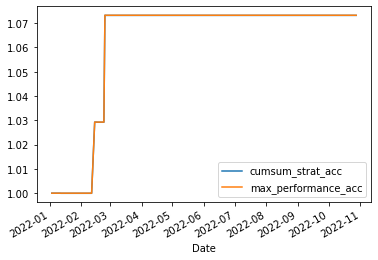

In [56]:
df_acc_testing[['cumsum_strat_acc', 'max_performance_acc']].plot()